**Download libraries**

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import seaborn as sns
from google.colab import drive
from google.colab import files
import sklearn
from sklearn.feature_selection import r_regression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression
from collections import Counter
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel



**Let us create a function that  takes a movie URL, scrapes various movie features using Beautiful Soup and returns the genre, description, title, rating, and timing in a tuple**

In [2]:
def get_rating_from_soup(soup):
  # Search for all elements with the class "fivestar-rating__current-rating"
  rating_v1 = soup.find_all("span", class_="fivestar-rating__current-rating")

  # Search for all elements with the class "fourstar-rating__current-rating"
  rating_v2 = soup.find_all("span", class_="fourstar-rating__current-rating")

  # Check if there are elements with class "fivestar-rating__current-rating"
  if len(rating_v1):
    # Get the first element with class "fivestar-rating__current-rating"
    zeroth_rating = rating_v1[0]

    # Extract the contents of the first element and remove leading/trailing whitespace
    content = zeroth_rating.contents[0]

    # Convert the extracted content to a string and store it as the movie_rating
    movie_rating = content.strip()
  # Check if there are elements with class "fourstar-rating__current-rating"
  elif len(rating_v2):
    # Get the first element with class "fourstar-rating__current-rating"
    zeroth_rating = rating_v2[0]

    # Extract the contents of the first element and remove leading/trailing whitespace
    content = zeroth_rating.contents[0]

    # Convert the extracted content to a string and store it as the movie_rating
    movie_rating = content.strip()
  else:
    # If no relevant elements are found, set movie_rating to -1
    movie_rating = -1

  # Return the extracted movie rating
  return movie_rating


**Let get genre of film from site Takflix**

In [3]:
def get_genre_from_soup(soup):
  # Search for all elements with the class "node-film__genres" (Version 1)
  genres_divs_v1 = soup.find_all("div", class_="node-film__genres")

  # Search for all elements with the class "node-film__genres" (Version 2)
  genres_divs_v2 = soup.find_all("div", class_="node-film__genres")

  # Check if there are elements with class "node-film__genres" (Version 1)
  if len(genres_divs_v1):
    # Get the first element with class "node-film__genres" (Version 1)
    zeroth_genre = genres_divs_v1[0]

    # Extract the contents of the first element and remove leading/trailing whitespace
    content = zeroth_genre.contents[0]

    # Store the extracted content as the movie_genre
    movie_genre = content.strip()
  # Check if there are elements with class "node-film__genres" (Version 2)
  elif len(genres_divs_v2):
    # Get the first element with class "node-film__genres" (Version 2)
    zeroth_genre = genres_divs_v2[0]

    # Extract the contents of the first element and remove leading/trailing whitespace
    content = zeroth_genre.contents[0]

    # Store the extracted content as the movie_genre
    movie_genre = content.strip()
  else:
    # If no relevant elements are found, set movie_genre to "Unknown"
    movie_genre = "Unknown"

  # Return the extracted movie genre
  return movie_genre


**Let make a function that scrape movie features(timing, description, title< timing)**

In [4]:
def scrape_movie_features(movie_url):
  # Send a GET request to the movie URL and get the page content
  page = requests.get(movie_url)

  # Parse the page content using Beautiful Soup
  soup = BeautifulSoup(page.content, "html.parser")

  # Find the rating, genres, description, timing, and title using the HTML tags and classes

  # Find all div elements with the class "node-film__genres"
  genres_divs = soup.find_all("div", class_="node-film__genres")

  # Find all div elements with the class "field--name-field-what-is-the-movie-about"
  description_divs = soup.find_all("div", class_="field--name-field-what-is-the-movie-about")

  # Find all div elements with the class "node-film__timimg"
  timing_1 = soup.find("div", class_="node-film__timimg")
  timing_2 = soup.find("div", class_="new-movies__timimg")

  if timing_1:
        # If "node-film__timimg" is found, we use it
        movie_timing = timing_1.get_text(strip=True)
  elif timing_2:
        # If "new-movies__timimg" is found, use it
        movie_timing = timing_2.get_text(strip=True)
  else:
        # If none of the tags are found, set the default value or process accordingly
        movie_timing = "There is no data "
  # Find all h1 elements with the class "node-film__title"
  movie_title_h1 = soup.find_all("h1", class_="node-film__title")

  # Extract the actual values from the tags and format them
  movie_rating = get_rating_from_soup(soup)  # Extract movie rating using a helper function

  movie_genre = get_genre_from_soup(soup)    # Extract movie genre using a helper function

  # Extract and clean the text from the first description div
  movie_description = description_divs[0].text.strip()

  # Extract and clean the text from the first movie title h1
  movie_title = movie_title_h1[0].text.strip()

  # Extract and clean the text from the timing div
  #movie_timing_1= timing_1[0].contents[0].strip()
  #movie_timing_2 = timing_2[0].strip()

  # Return the movie features as a tuple
  return movie_genre, movie_description, movie_title, movie_rating, movie_timing

**Function takes a movie search page URL, scrapes the URLs of all the movies listed on the page using Beautiful Soup, and returns them in a list**

In [5]:
def scrape_film_poster(movie_search_page_url):
  # Send a GET request to the movie search page URL and get the page content
  page = requests.get(movie_search_page_url)

  # Parse the page content using Beautiful Soup
  soup = BeautifulSoup(page.content, "html.parser")

  # Find all the film posters on the page and extract their URLs
  film_poster = soup.find_all("h4", class_="card-film-poster__title")
  url_films = []
  for element in film_poster:
    url = element.contents[1]['href']
    url_films.append(url)

  # Return the list of movie URLs
  return url_films

**Iterate over multiple pages of a website by changing the page number in the URL, call the "scrape_film_poster" function to get URLs of movies listed on each page, combines the results, removes duplicates, and returns them as a list of absolute movie URLs**

In [6]:
def scrape_all_film_poster(url, n_max_page):
  # Create an empty list to store the movie URLs
  url_films = []

  # Iterate over each page, up to a maximum number of pages specified by n_max_page
  for page in range(n_max_page):
    # Construct the URL of the current page by appending the page number to the base URL
    url_page = url + '?sort_by=created&page='+ str(page)

    # Call the "scrape_film_poster" function to get the URLs of movies listed on the current page
    url_films_page = scrape_film_poster(url_page)
    print (len(url_films_page))

    # If there are no more movie URLs on the current page, break out of the loop
    if len(url_films_page) == 0:
      break

    # Otherwise, append the movie URLs to the overall list
    url_films.extend(url_films_page)

  # Remove any duplicates from the list of movie URLs
  url_films = set(url_films)

  # Prepend the base URL to each movie URL and return the resulting list
  url_films = ['https://www.takflix.com' + url for url in url_films ]
  return url_films

**Scrape movie features for each URL in the list "url_films" using the "scrape_movie_features" function, and create a dictionary "movie_features" where each key is a movie title and its value is a tuple of movie genre, description, rating, and timing**

In [7]:
url_films = scrape_all_film_poster('https://www.takflix.com/uk/films',10)
movie_features = {}
for i,url in enumerate(url_films):
  print(f'scraping movie {i}')
  movie_genre,movie_description, movie_title,movie_rating,movie_timing = scrape_movie_features(url)
  movie_features[movie_title] = movie_genre,movie_description, movie_rating,movie_timing

48
48
48
26
0
scraping movie 0
scraping movie 1
scraping movie 2
scraping movie 3
scraping movie 4
scraping movie 5
scraping movie 6
scraping movie 7
scraping movie 8
scraping movie 9
scraping movie 10
scraping movie 11
scraping movie 12
scraping movie 13
scraping movie 14
scraping movie 15
scraping movie 16
scraping movie 17
scraping movie 18
scraping movie 19
scraping movie 20
scraping movie 21
scraping movie 22
scraping movie 23
scraping movie 24
scraping movie 25
scraping movie 26
scraping movie 27
scraping movie 28
scraping movie 29
scraping movie 30
scraping movie 31
scraping movie 32
scraping movie 33
scraping movie 34
scraping movie 35
scraping movie 36
scraping movie 37
scraping movie 38
scraping movie 39
scraping movie 40
scraping movie 41
scraping movie 42
scraping movie 43
scraping movie 44
scraping movie 45
scraping movie 46
scraping movie 47
scraping movie 48
scraping movie 49
scraping movie 50
scraping movie 51
scraping movie 52
scraping movie 53
scraping movie 54
scrapi

**Download movie_features**

In [8]:
movie_features

{'Толока': ('драма,\n        історичний',
  'У Тараса Шевченка є маленька балада про те, як закохалися у Катерину троє козаків. Свій вибір Катерина довірила долі: пообіцяла стати дружиною тому, хто визволить з полону її брата. Двоє з трьох козаків загинули, намагаючись виконати умови договору, третьому вдалося врятувати брата, але брат Катерини виявився не братом, а її коханим… Фінал поезії відсувається надовго – чекати Катерині доведеться не одне століття, не старіючи та не втрачаючи надії.\nЦя розповідь, наче притча, пролітає крізь історію України, відтворює її драматичні та героїчні епізоди. Кожне випробування руйнує й хату Катерини. Але вона вперто, як і сотні поколінь українців, знову й знову підіймає її з руїн.\xa0Вік української хати короткий\xa0— від війни до війни. Якби не толока, не було б де й зустріти свого коханого. Завдяки толоці жодна хата в Україні ніколи не була «скраю», завжди у центрі громади.',
  '4.1',
  '117'),
 'Природа. Фільм третій': ('драма',
  'Соломія прагне

**Create dataframe from movie features**

In [9]:
films_dataframe = pd.DataFrame(
    [{"Name": name, "Genre": genre,"Description" : description, "Timing" : timing, "Rating" : rating} for name, (genre, description,rating,timing) in movie_features.items()])

In [10]:
print(len(movie_features))

170


In [11]:
films_dataframe

,Name,Genre,Description,Timing,Rating
0,Толока,"драма,\n історичний","У Тараса Шевченка є маленька балада про те, як...",117,4.1
1,Природа. Фільм третій,драма,Соломія прагне не бути залежною ні від своїх б...,64,4.6
2,Кров,драма,Молода віолончелістка Настя закохана в свого д...,13,3.5
3,Штангіст,драма,Петро — професійний важкоатлет. Під час підгот...,30,4.1
4,Чачьо,драма,Януш виріс в консервативній ромській громаді у...,20,4.1
...,...,...,...,...,...
165,Поза зоною,драма,Люба працює на кондитерській фабриці. Її син п...,28,4.2
166,Красна Маланка,драма,Це історія про долі людей з румунського села К...,53,4.6
167,Котики,драма,Дві дівчини у львівській квартирі розпочинають...,8,4.5
168,Кіборги. Герої не вмирають,драма,"Вересень 2014 року, Донецький аеропорт. Україн...",110,4.8


**This function takes a string "description" as input, counts the number of vowels in it, and returns the count as an integer**

In [12]:
def count_des_vowels(description):
    # If the description is None, return 0
    if description is None:
        return 0

    # Initialize a counter for the number of vowels
    count_vowels = 0

    # Define a string of vowels in lowercase
    vowels = 'АЕЄИІЇОУЮЯ'.lower()

    # Iterate over each character in the description
    for char in description:
        # If the character is a vowel, increment the vowel counter
        if char in vowels:
            count_vowels += 1

    # Return the total count of vowels in the description
    return count_vowels

**This function takes a string as input, counts the number of consonants in the string using a defined set of consonants, and returns the count of consonants**

In [13]:
def count_des_consonants(description):
    # Check if the input is not a string, if not return 0
    if not isinstance(description, str):
        return 0

    # Initialize a counter for the number of consonants
    count_consonants = 0

    # Define a string of consonants in lowercase
    consonants = 'БВГҐДЖ3ЙКЛМНПРСТФXЦЧШЩ'.lower()

    # Iterate over each character in the description
    for char in description:
        # If the character is a consonant, increment the consonant counter
        if char in consonants:
            count_consonants += 1

    # Return the total count of consonants in the description
    return count_consonants

In [14]:
films_dataframe['vowels'] = films_dataframe['Description'].apply(count_des_vowels)

In [15]:
films_dataframe['consonants'] = films_dataframe['Description'].apply(count_des_consonants)

In [16]:
films_dataframe

,Name,Genre,Description,Timing,Rating,vowels,consonants
0,Толока,"драма,\n історичний","У Тараса Шевченка є маленька балада про те, як...",117,4.1,318,336
1,Природа. Фільм третій,драма,Соломія прагне не бути залежною ні від своїх б...,64,4.6,91,97
2,Кров,драма,Молода віолончелістка Настя закохана в свого д...,13,3.5,65,80
3,Штангіст,драма,Петро — професійний важкоатлет. Під час підгот...,30,4.1,68,88
4,Чачьо,драма,Януш виріс в консервативній ромській громаді у...,20,4.1,97,117
...,...,...,...,...,...,...,...
165,Поза зоною,драма,Люба працює на кондитерській фабриці. Її син п...,28,4.2,57,59
166,Красна Маланка,драма,Це історія про долі людей з румунського села К...,53,4.6,114,125
167,Котики,драма,Дві дівчини у львівській квартирі розпочинають...,8,4.5,167,207
168,Кіборги. Герої не вмирають,драма,"Вересень 2014 року, Донецький аеропорт. Україн...",110,4.8,255,318


**Create a scatter plot using Seaborn library to visualize the relationship between the count of vowels in movie descriptions and their ratings**

<Axes: xlabel='vowels', ylabel='Rating'>

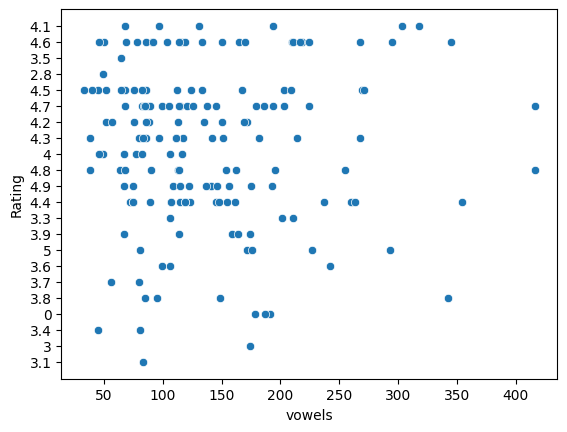

In [17]:
sns.scatterplot(data = films_dataframe, x = films_dataframe['vowels'], y =films_dataframe['Rating'])

**Create a scatter plot using Seaborn library to visualize the relationship between the count of consonants in movie descriptions and their ratings**

<Axes: xlabel='consonants', ylabel='Rating'>

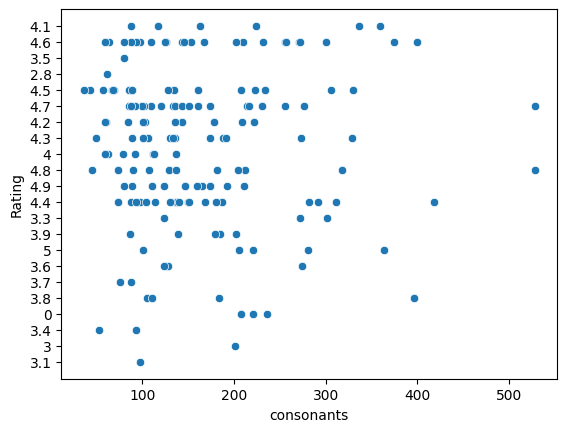

In [18]:
sns.scatterplot(data = films_dataframe, x = films_dataframe['consonants'], y =films_dataframe['Rating'] )

**Converts a timing string in the format "x min." to an integer value of x**

In [19]:
def transform_timing_toint(timing):
  return int(timing)

In [20]:
films_dataframe['Timing'] = films_dataframe['Timing'].apply(transform_timing_toint)

**Create a histogramm for timing of films**

array([[<Axes: title={'center': 'Timing'}>]], dtype=object)

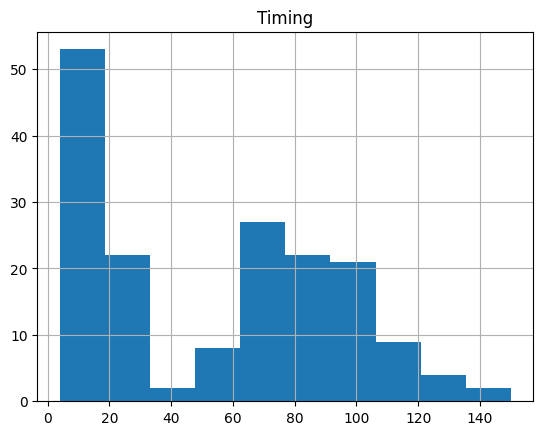

In [21]:
films_dataframe.hist('Timing')

**Select movies with duration less than 40 minutes**

In [22]:
films_dataframe_less40 = films_dataframe[films_dataframe['Timing'] < 40]
films_dataframe_less40

,Name,Genre,Description,Timing,Rating,vowels,consonants
2,Кров,драма,Молода віолончелістка Настя закохана в свого д...,13,3.5,65,80
3,Штангіст,драма,Петро — професійний важкоатлет. Під час підгот...,30,4.1,68,88
4,Чачьо,драма,Януш виріс в консервативній ромській громаді у...,20,4.1,97,117
5,Нормальна,драма,Після невдалої вечірки дівчина вирішує розпові...,13,2.8,49,61
6,Гострий біль,драма,У Толіка була мрія: він хотів бути перевертаче...,11,4.5,45,57
...,...,...,...,...,...,...,...
162,Цілковита незнайомка,драма,Біль і розчарування від втрати близької людини...,13,3.8,85,110
164,Колишні,драма,"Книжковий ринок Петрівка – місце, куди зносять...",12,3.7,56,75
165,Поза зоною,драма,Люба працює на кондитерській фабриці. Її син п...,28,4.2,57,59
167,Котики,драма,Дві дівчини у львівській квартирі розпочинають...,8,4.5,167,207


**Select movies with duration greater than or equal to 40 minutes**

In [23]:
films_dataframe_bigger40 = films_dataframe[films_dataframe['Timing'] >= 40]
films_dataframe_bigger40

,Name,Genre,Description,Timing,Rating,vowels,consonants
0,Толока,"драма,\n історичний","У Тараса Шевченка є маленька балада про те, як...",117,4.1,318,336
1,Природа. Фільм третій,драма,Соломія прагне не бути залежною ні від своїх б...,64,4.6,91,97
7,Какофонія Донбасу,історичний,"Що поєднує Дзиґу Вертова, гурт ""Пающіє труси"" ...",61,4.7,99,109
8,Вирок. Фільм четвертий,"драма,\n трагікомедія",Гумористичний фільм «Вирок» завершує історію н...,71,4.2,135,143
9,МІФ,фільм-портрет,Це історія життя Василя Сліпака – оперного спі...,62,4.6,133,143
...,...,...,...,...,...,...,...
159,Зошит війни,драма,Фільм створений з особистих відеозаписів із те...,70,4.9,146,174
160,Поводир,"історичний,\n драма","Україна, тридцяті роки. Американський інженер ...",122,4.6,217,272
163,Віктор_Робот,"антиутопія,\n для дітей","Далеке майбутнє. Штучна зірка, що має забезпеч...",71,4.4,119,130
166,Красна Маланка,драма,Це історія про долі людей з румунського села К...,53,4.6,114,125


**Generate a visualization that compares the ratings of movies with a runtime  less than 40 minutes to the counts of vowels and consonants, using two subplots containing scatterplots for each count**

<Axes: title={'center': 'Time is over 40 - Consonants'}, xlabel='consonants', ylabel='Rating'>

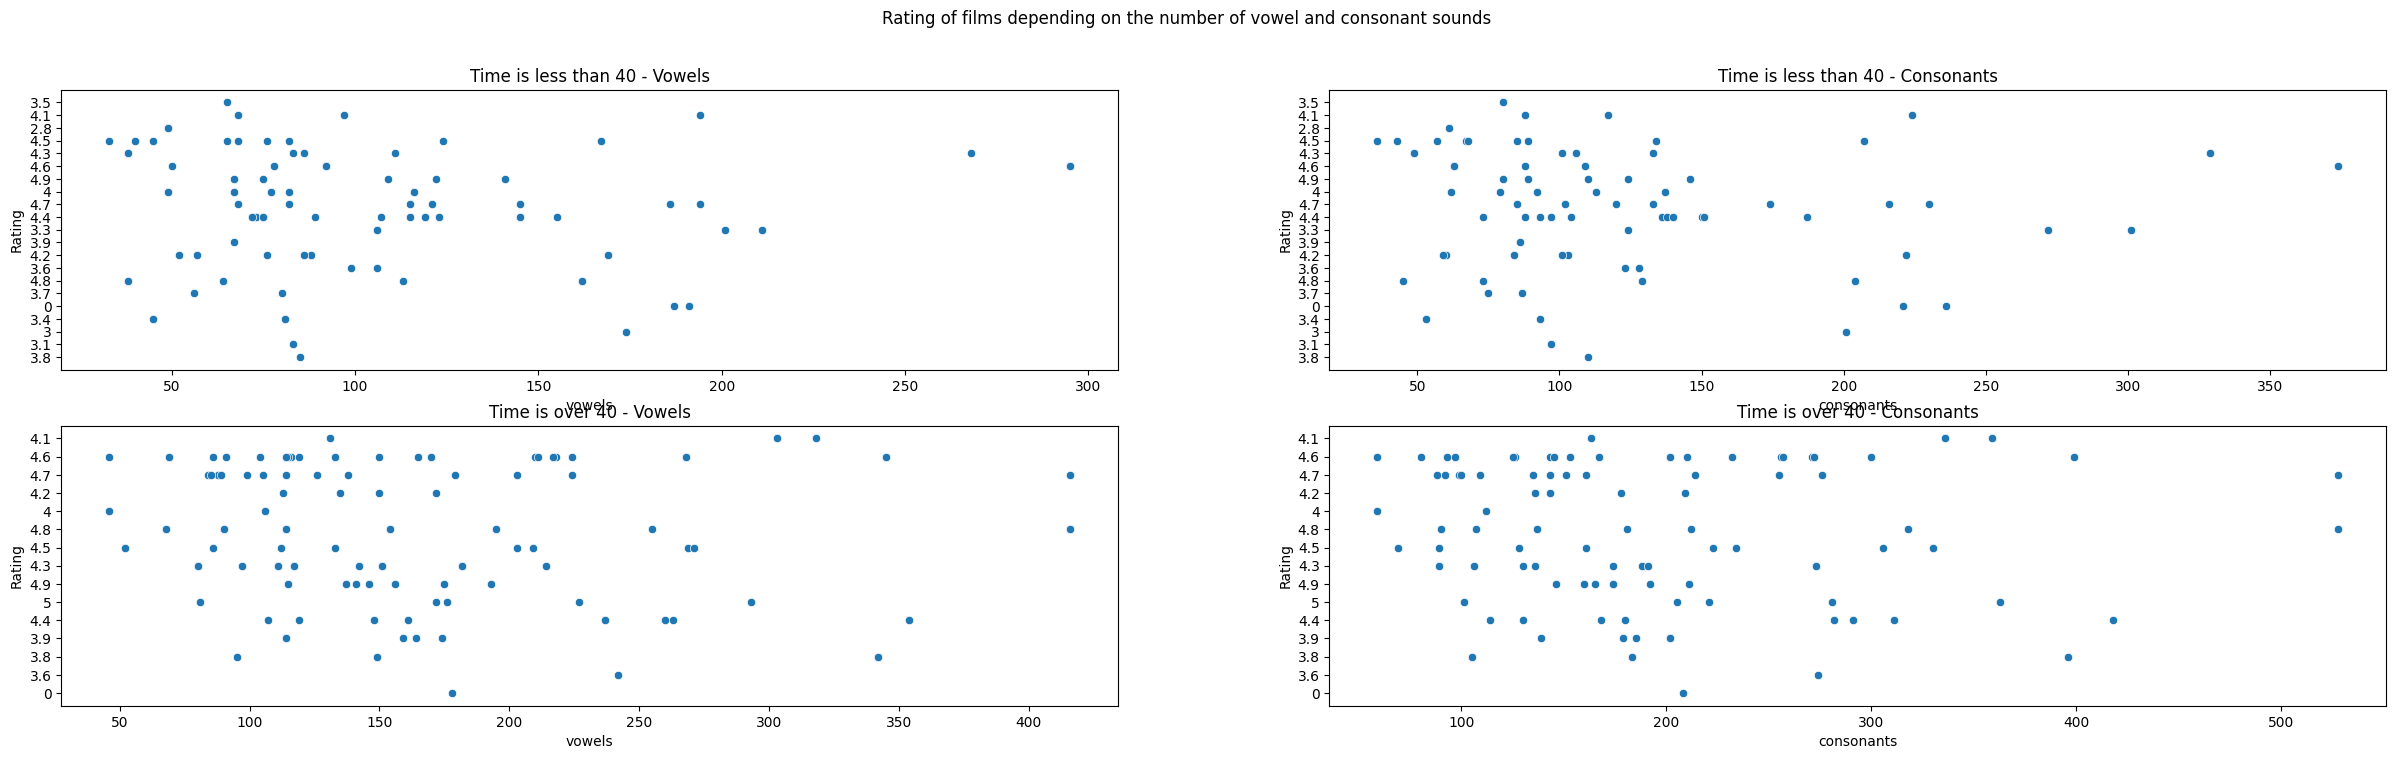

In [24]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 2, figsize=(30, 8))

# Add a title to the overall figure
plt.suptitle('Rating of films depending on the number of vowel and consonant sounds')

# Add a title to the left subplot
axes[0, 0].set_title('Time is less than 40 - Vowels')

# Create a scatter plot for the number of vowels versus the rating in the left subplot
sns.scatterplot(data=films_dataframe_less40, x='vowels', y='Rating', ax=axes[0, 0])

# Add a title to the right subplot
axes[0, 1].set_title('Time is less than 40 - Consonants')

# Create a scatter plot for the number of consonants versus the rating in the right subplot
sns.scatterplot(data = films_dataframe_less40, x='consonants', y='Rating', ax=axes[0, 1])

# Add a title to the left subplot
axes[1, 0].set_title('Time is over 40 - Vowels')

# Create a scatter plot for the number of vowels versus the rating in the left subplot
sns.scatterplot(data=films_dataframe_bigger40 , x='vowels', y='Rating', ax=axes[1, 0])

# Add a title to the right subplot
axes[1, 1].set_title('Time is over 40 - Consonants')

# Create a scatter plot for the number of consonants versus the rating in the right subplot
sns.scatterplot(data=films_dataframe_bigger40 , x='consonants', y='Rating', ax=axes[1, 1])

**Сreate a figure with two subplots, sets the main title and plots scatter plots for the dependence of movie ratings on the duration of the movie, for two different conditions, one where the duration is greater than 40 minutes and the other where the duration is less than 40 minutes**

<Axes: title={'center': 'Less than 40 minutes'}, xlabel='Rating', ylabel='Timing'>

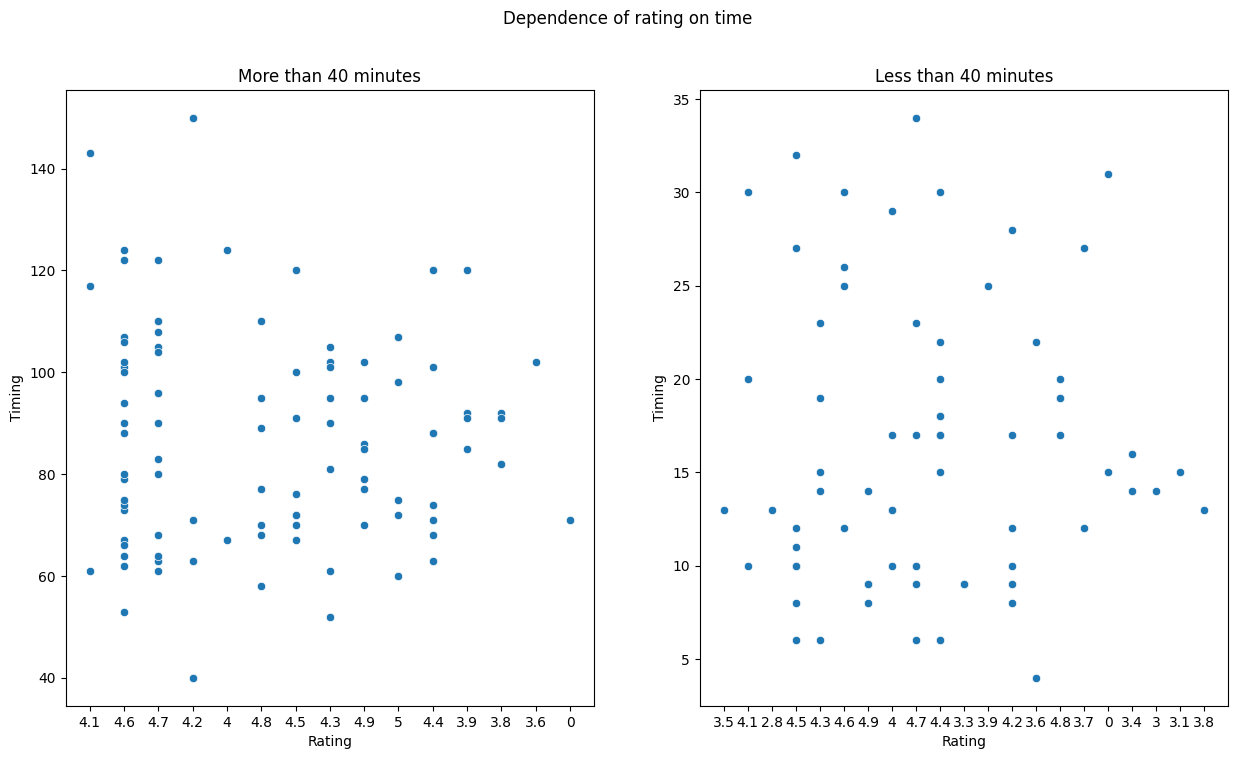

In [25]:
# Create a figure with two subplots and set the size
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Set the main title of the figure
plt.suptitle('Dependence of rating on time')

# Set the title and plot a scatter plot on the first subplot
axes[0].set_title('More than 40 minutes')
sns.scatterplot(data = films_dataframe_bigger40, x='Rating', y='Timing', ax=axes[0])

# Set the title and plot a scatter plot on the second subplot
axes[1].set_title('Less than 40 minutes')
sns.scatterplot(data = films_dataframe_less40, x='Rating', y='Timing', ax=axes[1])

**Define vowels and consonants**

In [26]:
vowels = 'АЕЄИІЇОУЮЯ'.lower()
consonants = 'БВГҐДЖ3ЙКЛМНПРСТФXЦЧШЩ'.lower()

**Define a function called "index_vowel" that takes a string as input and returns the index of the first vowel in the string or None if no vowels are present**

In [27]:
def index_vowel(word):
  # Initialize an empty list to store the indices of the vowels
  index =[]

  # Iterate over the vowels and find their indices in the word
  for vowel in vowels:
    idx = word.find(vowel)

    # If a vowel is found in the word, append its index to the list of indices
    if idx != -1:
      index.append(idx)

  # Return None if no vowels were found in the word, otherwise return the index of the first vowel
  return None if len(index) == 0 else min(index)

**This function takes a word as input, divides it into syllables based on the positions of vowels in the word, and returns a list of syllables**

In [28]:

def get_syllables(word):
  syllables = []  # create an empty list to store the syllables
  idx_syllable_start = 0  # initialize the start index of the syllable
  vowel_offset = index_vowel(word[idx_syllable_start:])  # find the index of the first vowel in the word

  # loop through the word to find the syllables
  while True:
    if vowel_offset is None:  # if no more vowels in the word, exit the loop
      break

    # find the index of the next vowel after the current syllable
    next_vowel_offset = index_vowel(word[idx_syllable_start + vowel_offset+1:])

    if next_vowel_offset is None:  # if no more vowels after the current syllable, the syllable ends at the end of the word
      idx_syllable_end = len(word)
    else:
      idx_syllable_end = vowel_offset + idx_syllable_start + 1  # otherwise, the syllable ends at the index of the next vowel

    # slice the word to get the current syllable and append it to the list of syllables
    syllable = word[idx_syllable_start:idx_syllable_end]
    syllables.append(syllable)

    # update the start index of the next syllable and the index of the next vowel
    idx_syllable_start += vowel_offset + 1
    vowel_offset = next_vowel_offset

  return syllables  # return the list of syllables


**This function takes a text description as input, preprocesses it to remove special characters and split it into words, and then uses the get_syllables() function to extract the syllables of each word, returning a list of all syllables in the description**

In [29]:
def get_description_syllables(description):

  # Convert the description to lowercase
  description = description.lower()

  # Define a string of symbols that should be removed from the description
  symbols = '!()?.,[]{}=+_-%#*":;/|\\\n\xa0'+"'"

  # Remove each symbol from the description string using the replace() method
  for symbol in symbols:
    description = description.replace(symbol,' ')

  # Split the cleaned description string into a list of words using the split() method
  words = description.split(' ')

  # Remove any empty strings from the list of words
  words = [word for word in words if word != '']

  # Create an empty list to hold the syllables found in the description
  description_syllables = []

  # Loop through each word in the list of words
  for word in words:

    # Get a list of syllables for the current word using the get_syllables() function
    word_syllables = get_syllables(word)

    # Extend the list of description syllables with the syllables found in the current word
    description_syllables.extend(word_syllables)

  # Return the list of description syllables
  return description_syllables

**Creates a list of syllables**

In [30]:
syllables = []
for description in films_dataframe['Description']:
  syllables.extend(get_description_syllables(description))
print(syllables)

['у', 'та', 'ра', 'са', 'ше', 'вче', 'нка', 'є', 'ма', 'ле', 'нька', 'ба', 'ла', 'да', 'про', 'те', 'як', 'за', 'ко', 'ха', 'ли', 'ся', 'у', 'ка', 'те', 'ри', 'ну', 'тро', 'є', 'ко', 'за', 'ків', 'свій', 'ви', 'бір', 'ка', 'те', 'ри', 'на', 'до', 'ві', 'ри', 'ла', 'до', 'лі', 'по', 'о', 'бі', 'ця', 'ла', 'ста', 'ти', 'дру', 'жи', 'но', 'ю', 'то', 'му', 'хто', 'ви', 'зво', 'лить', 'по', 'ло', 'ну', 'ї', 'ї', 'бра', 'та', 'дво', 'є', 'трьох', 'ко', 'за', 'ків', 'за', 'ги', 'ну', 'ли', 'на', 'ма', 'га', 'ю', 'чись', 'ви', 'ко', 'на', 'ти', 'у', 'мо', 'ви', 'до', 'го', 'во', 'ру', 'тре', 'тьо', 'му', 'вда', 'ло', 'ся', 'вря', 'ту', 'ва', 'ти', 'бра', 'та', 'а', 'ле', 'брат', 'ка', 'те', 'ри', 'ни', 'ви', 'я', 'ви', 'вся', 'не', 'бра', 'том', 'а', 'ї', 'ї', 'ко', 'ха', 'ним…', 'фі', 'нал', 'по', 'е', 'зі', 'ї', 'ві', 'дсу', 'ва', 'є', 'ться', 'на', 'до', 'вго', 'че', 'ка', 'ти', 'ка', 'те', 'ри', 'ні', 'до', 'ве', 'де', 'ться', 'не', 'о', 'дне', 'сто', 'лі', 'ття', 'не', 'ста', 'рі', 'ю', '

In [31]:
len(syllables)

23878

**Сount the most frequently occurring syllables in a given text and display them.**

In [32]:
all_syllables = Counter(syllables).most_common(10)
print(all_syllables)
print(len(all_syllables))
small_all_syllables = [syll[0] for syll in all_syllables]



[('на', 588), ('є', 523), ('ї', 493), ('по', 406), ('го', 402), ('і', 347), ('ти', 341), ('ро', 340), ('у', 332), ('до', 323)]
10


**Calculate the frequency of each syllable in a given string by calling the get_description_syllables function to get a list of syllables and then using a list comprehension to count the occurrences of each syllable in the string**

In [33]:
def count_syllables(description, syllables):
    # Get the syllables from the description
    description_syllables = get_description_syllables(description)

    # Initialize a counter to keep track of the syllable count
    syllable_count = 0

    # Iterate through each syllable in the description
    for syll in description_syllables:
        # Check if the syllable is in the list of known syllables
        if syll in syllables:
            # If the syllable is found in the list, increment the count
            syllable_count += 1

    # Return the total count of syllables found in the description
    return syllable_count

**Сalculates the number of syllables in each description (string) from the 'Description' column in your DataFrame and stores these counts in the 'all_description_syl' list. The result is a list where each element corresponds to the count of syllables in the respective film description.**

In [34]:
all_description_syl = []  # Initialize an empty list to store the counts of syllables in descriptions

# Iterate through each description in the 'Description' column of the DataFrame
for des in films_dataframe['Description']:
    # Split the description into words (assuming that's what you meant)
    description_words = des.split()  # Split the description into words

    # Count the syllables in the current description using the count_syllables function
    description_syl = count_syllables(des, syllables)

    # Append the count of syllables to the 'all_description_syl' list
    all_description_syl.append(description_syl)

# 'all_description_syl' now contains the counts of syllables for each description in the DataFrame

In [35]:
all_description_syl

[323,
 93,
 66,
 68,
 101,
 50,
 50,
 101,
 136,
 138,
 87,
 120,
 109,
 298,
 200,
 276,
 144,
 99,
 49,
 424,
 184,
 199,
 79,
 134,
 73,
 84,
 202,
 156,
 221,
 90,
 165,
 116,
 72,
 67,
 183,
 155,
 177,
 139,
 89,
 142,
 78,
 228,
 127,
 107,
 54,
 145,
 175,
 101,
 193,
 160,
 108,
 273,
 167,
 116,
 138,
 164,
 86,
 70,
 137,
 87,
 178,
 116,
 80,
 206,
 34,
 68,
 77,
 273,
 67,
 166,
 89,
 348,
 68,
 157,
 105,
 88,
 121,
 174,
 192,
 143,
 113,
 243,
 146,
 424,
 45,
 52,
 80,
 246,
 177,
 108,
 295,
 177,
 207,
 230,
 120,
 89,
 361,
 91,
 111,
 119,
 308,
 108,
 46,
 123,
 119,
 229,
 150,
 76,
 199,
 80,
 116,
 115,
 78,
 82,
 172,
 68,
 75,
 187,
 270,
 214,
 235,
 82,
 111,
 90,
 123,
 262,
 46,
 348,
 151,
 65,
 149,
 180,
 38,
 106,
 84,
 161,
 110,
 96,
 82,
 266,
 191,
 84,
 69,
 215,
 119,
 92,
 117,
 119,
 68,
 85,
 129,
 119,
 119,
 211,
 86,
 41,
 52,
 212,
 153,
 147,
 221,
 169,
 86,
 121,
 56,
 58,
 115,
 168,
 258,
 41]

**Сalculates the number of most using syllables in each description (string) from the 'Description' column in your DataFrame and stores these counts in the 'most_common' list. The result is a list where each element corresponds to the count of syllables in the respective film description.**

In [36]:
all = []  # Initialize an empty list to store the counts of specific syllables in descriptions

# Iterate through each description in the 'Description' column of the DataFrame
for des in films_dataframe['Description']:
    # Split the description into words
    description_words = des.split()  # Split the description into words

    # Count the specific syllables in the current description using the count_syllables function
    description_syl = count_syllables(des, small_all_syllables)

    # Append the count of specific syllables to the 'all' list
    all.append(description_syl)

# 'all' now contains the counts of specific syllables for each description in the DataFrame

In [37]:
films_dataframe['All_syllables'] = all_description_syl

In [38]:
films_dataframe['most_common'] = all

In [39]:
films_dataframe

,Name,Genre,Description,Timing,Rating,vowels,consonants,All_syllables,most_common
0,Толока,"драма,\n історичний","У Тараса Шевченка є маленька балада про те, як...",117,4.1,318,336,323,64
1,Природа. Фільм третій,драма,Соломія прагне не бути залежною ні від своїх б...,64,4.6,91,97,93,13
2,Кров,драма,Молода віолончелістка Настя закохана в свого д...,13,3.5,65,80,66,7
3,Штангіст,драма,Петро — професійний важкоатлет. Під час підгот...,30,4.1,68,88,68,11
4,Чачьо,драма,Януш виріс в консервативній ромській громаді у...,20,4.1,97,117,101,17
...,...,...,...,...,...,...,...,...,...
165,Поза зоною,драма,Люба працює на кондитерській фабриці. Її син п...,28,4.2,57,59,58,14
166,Красна Маланка,драма,Це історія про долі людей з румунського села К...,53,4.6,114,125,115,18
167,Котики,драма,Дві дівчини у львівській квартирі розпочинають...,8,4.5,167,207,168,29
168,Кіборги. Герої не вмирають,драма,"Вересень 2014 року, Донецький аеропорт. Україн...",110,4.8,255,318,258,38


In [40]:
films_dataframe['Rating'].astype(str)

0      4.1
1      4.6
2      3.5
3      4.1
4      4.1
      ... 
165    4.2
166    4.6
167    4.5
168    4.8
169    4.3
Name: Rating, Length: 170, dtype: object

**Find a p_value and understand if rating and common syllables is statistically significant**.

In [41]:
from scipy import stats

In [44]:
# Convert 'Rating' and 'All' columns to numeric
films_dataframe['Rating'] = pd.to_numeric(films_dataframe['Rating'], errors='coerce')
films_dataframe['most_common'] = pd.to_numeric(films_dataframe['most_common'], errors='coerce')

# Perform the t-test
t_statistic, p_value = stats.ttest_ind(films_dataframe['Rating'], films_dataframe['most_common'], nan_policy='omit')

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# Determine if the difference is significant at a specific alpha level (e.g., 0.05)
alpha = 0.05
if p_value <= alpha:
    print("The difference between ratings and common syllables count is statistically significant.")
else:
    print("There is no statistically significant difference between ratings and common syllables count.")

T-Statistic: -18.97581222959414
P-Value: 3.5197686668535244e-55
The difference between ratings and common syllables count is statistically significant.


**Find a p_value and understand if rating and vowels is statistically significant.**

In [45]:
# Convert 'Rating' and 'All' columns to numeric
films_dataframe['Rating'] = pd.to_numeric(films_dataframe['Rating'], errors='coerce')
films_dataframe['vowels'] = pd.to_numeric(films_dataframe['vowels'], errors='coerce')

# Perform the t-test
t_statistic, p_value = stats.ttest_ind(films_dataframe['Rating'], films_dataframe['vowels'], nan_policy='omit')

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# Determine if the difference is significant at a specific alpha level (e.g., 0.05)
alpha = 0.05
if p_value <= alpha:
    print("The difference between ratings and common syllables count is statistically significant.")
else:
    print("There is no statistically significant difference between ratings and common syllables count.")

T-Statistic: -23.268649923466924
P-Value: 3.6190698940723197e-72
The difference between ratings and common syllables count is statistically significant.


**Use method ANOVA to understand how most common syllables and all syllables influence on rating**

In [47]:
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Підготовка даних для аналізу
formula = 'Rating ~ C(most_common) + C(All_syllables) + C(most_common):C(All_syllables)'
model = ols(formula, data=films_dataframe).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Виведення результатів
print(anova_table)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 50, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 122, but rank is 4
  warnings.warn('covariance of constraints does not have full '


                                      sum_sq      df          F    PR(>F)
C(most_common)                    115.796671    50.0  18.235696  0.007936
C(All_syllables)                  144.629638   122.0   9.334558  0.015360
C(most_common):C(All_syllables)  3878.175725  6100.0   5.006036  0.037831
Residual                            0.635000     5.0        NaN       NaN


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6100, but rank is 162
  warnings.warn('covariance of constraints does not have full '


**The provided code snippet demonstrates a basic machine learning workflow for performing linear regression on a film dataset. It splits the dataset into training and testing sets, trains a linear regression model to predict film ratings based on common features, and evaluates the model's accuracy using the Mean Squared Error (MSE). By calculating and printing the MSE, the code offers a quantitative assessment of how well the model's predictions align with the actual ratings, providing valuable insights into its performance.**

In [50]:

# Load your dataset from a CSV file or another source
# You can replace this with your 'films_dataframe' dataset

# Split the data into training and testing sets
train_data, test_data = train_test_split(films_dataframe, test_size=0.2, random_state=42)

# Define variables for training and prediction
X_train = train_data[['most_common']]  # Features for training (e.g., 'All' columns)
y_train = train_data['Rating']  # Target variable for training (e.g., 'Rating')
X_test = test_data[['most_common']]    # Features for testing
y_test = test_data['Rating']    # Actual ratings for testing

# Create a linear regression model and train it on the training data
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's accuracy using mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse,y_pred)

Mean Squared Error: 0.13223029967670724 [4.30903263 4.28259476 4.28259476 4.22971902 4.26937583 4.26496952
 4.24734427 4.28259476 4.30682948 4.30242317 4.32886104 4.28479792
 4.26937583 4.27378214 4.23412533 4.23632849 4.2209064  4.22971902
 4.2407348  4.29361054 4.35309575 4.26937583 4.2605632  4.23192218
 4.25395374 4.26937583 4.24734427 4.23192218 4.24954742 4.2759853
 4.26276636 4.2407348  4.24734427 4.24514111]


**The dif_syllables function takes in a number n, two lists y and descriptions, extracts the most common n syllables from the descriptions, uses the count_syllables function to count the frequency of these syllables in each description, trains a linear regression model on the resulting feature matrix x and the target variable y, and returns the predicted values and R-squared score for the test set**

In [51]:

def dif_sylables(n, y, descriptions):
    # Get the `n` most common syllables in the `descriptions` list
    all_syllables = Counter(syllables).most_common(n)
    small_all_syllables = [syll[0] for syll in all_syllables]

    # Calculate the frequency of each syllable in each description
    all_syllable_count = [count_syllables(description, small_all_syllables) for description in descriptions]

    # Split the feature matrix `x` and target variable `y` into training and test sets
    x = np.array(all_syllable_count).reshape(-1, 1)
    y = y
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    # Train a linear regression model on the training data
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Predict the target variable for the test data and calculate the R-squared score
    y_pred_test = model.predict(x_test)
    r2_test = model.score(x_test, y_test)
    mse = mean_squared_error(y_test, y_pred_test)
    y_pred = model.predict(x)
    coef_1 = model.coef_[0]
    coef_2 = model.intercept_
    return y_pred_test, r2_test, mse, coef_1, coef_2

In [52]:
y_pred_test, r2_test ,mse,  coef_1, coef_2 = dif_sylables(10,y = films_dataframe['Rating'],descriptions =films_dataframe['Description'] )

In [53]:
y_pred_test, r2_test, mse, coef_1, coef_2

(array([4.23795848, 4.25386128, 4.30687058, 4.25916221, 4.28566686,
        4.21675476, 4.35457896, 4.23265755, 4.28566686, 4.275065  ,
        4.25916221, 4.3439771 , 4.33337523, 4.19025011, 4.3439771 ,
        4.26446314, 4.20085197, 4.26446314, 4.25386128, 4.275065  ,
        4.37578268, 4.24856035, 4.3969864 , 4.42879199, 4.21675476,
        4.28566686, 4.28036593, 4.19025011, 4.51360687, 4.3280743 ,
        4.26446314, 4.32277337, 4.23795848, 4.31747244]),
 -0.03305055328168338,
 0.6863530682893287,
 0.005300930571975175,
 4.169046387058077)

**The get_recommendations function now takes the 'description' as an additional argument, and it calculates movie recommendations based on the textual content similarities found in movie descriptions. The TF-IDF matrix is constructed using these descriptions, and the cosine similarity matrix is generated to provide recommendations for the specified movie title ('Зошит війни').**

In [54]:
name = films_dataframe['Name']

In [56]:
def get_recommendations(title, cosine_sim, name):
    # Get the index of the movie that matches the title
    idx = name[name == title].index[0]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return name.iloc[movie_indices]

In [59]:
description = films_dataframe['Description']

In [60]:
tfidf = TfidfVectorizer()

# Construct the TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(description)

# Generate the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Generate recommendations
print(get_recommendations('Зошит війни', cosine_sim, name))

13                  Вхід через балкон
154               Явних проявів немає
90     Не хвилюйся, двері відчиняться
87                             Номери
130                             Гамер
51                Між небом та горами
93                      Життя на межі
114     Земля блакитна, ніби апельсин
160                           Поводир
128                 Заміж за іноземця
Name: Name, dtype: object
